<a href="https://colab.research.google.com/github/sjunc/AI-Library/blob/main/class/W11_Let_There_Be_Color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11주차 채색 모델

In [27]:
import kagglehub

#Download lastes version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


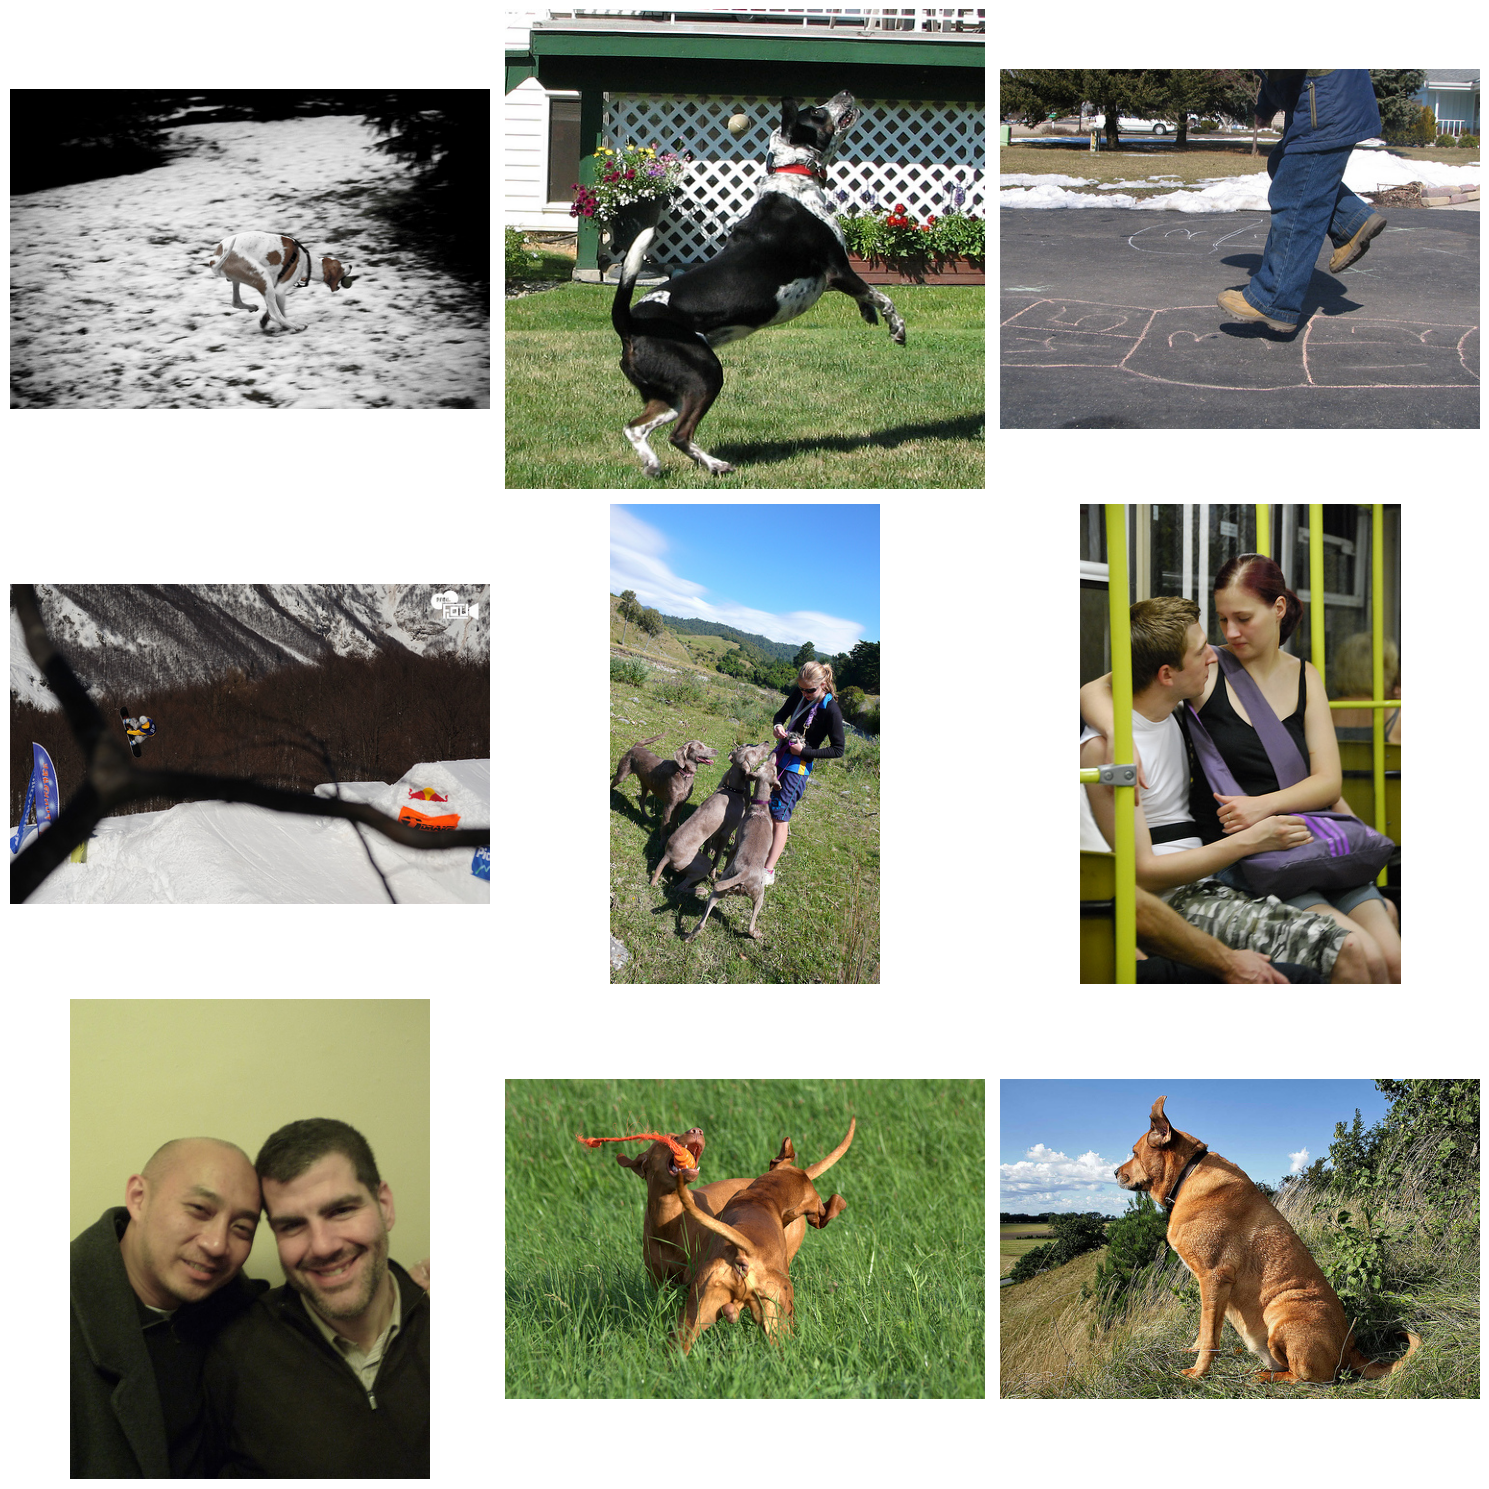

In [28]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

# 데이터셋의 이미지 경로 설정

image_path = '/kaggle/input/flickr8k/Images/*.jpg'

# 데이터셋에 포함된 이미지 파일명을 불러옴
imgs = glob.glob(image_path)

# 이미지 9개를 표기

plt.figure(figsize = (15, 15))
for i in range(min(9, len(imgs))):
    img = Image.open(imgs[i])
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')   # 축 숨기기
plt.tight_layout()
plt.show()

In [29]:
import cv2
import numpy as np

from torch.utils.data import Dataset

# RGB를 LAB으로 변환
# L: 밝기만 나오는 흑백 이미지, A/B: 컬러가 있는 채널
# L만 입력 데이터 사용하고, a, b 채널은 정답 데이터로 사용하기 위함

def rgb2lab(rgb):
  return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

# LAB를 RGB로 변환하는 함수 (이미지 출력시)
def lab2rgb(lab):
  return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# 학습에 이용할 데이터셋 객체
class AutoColoring(Dataset):
  def __init__(self):     # 데이터셋의 초기화 함수
      self.data = glob.glob("/kaggle/input/flickr8k/Images/*.jpg")

  def __len__(self):     # 사용 가능한 데이터셋의 길이를 반환하는 함수
      return len(self.data)

  def __getitem__(self, i): # 데이터 하나를 호출하는 함수
      # RGB 이미지를 불러오고 크기를 256X256 으로 리사이즈
      rgb = np.array(Image.open(self.data[i]).resize((256, 256)))
      # RGB -> LAB 색공간으로 변환
      lab = rgb2lab(rgb)

      # (H, W, C) -> (C, H, W) 순서로 바꿔줌 (Pytorch는 채널이 앞)
      # 파이토치는 채널이 가장 앞에 와야 하므로 transpose
      lab = lab.transpose((2, 0, 1)).astype(np.float32)

      return lab[0], lab[1:]

      # lab[0]: 입력 이미지의 밝기 정보 (L채널)
      # lab[1:]: 정답 이미지의 색상 정보 (a,b 채널)


In [30]:
import torch
import torch.nn as nn

# Low Level Feature Extractor
# 흑백 이미지를 입력받아 점차적으로 해상도를 줄이며 채널 수를 늘려가며 특징 추출
# 합성곱 -> 배치 정규화 -> 활성화 함수

# 입력: (1, h, w) -> (512, h/8, w/8) 512 채널의 특징맵
class LowLevel(nn.Module):
    def __init__(self):
      # 로우 레벨 특징 추출기를 구성하는 층의 정의
      super(LowLevel, self).__init__()

      self.low1 = nn.Conv2d(1, 64, kernel_size=3, stride = 2, padding =1)
      self.lb1 = nn.BatchNorm2d(64)
      self.low2 = nn.Conv2d(64, 128, kernel_size=3, stride = 1, padding =1)
      self.lb2 = nn.BatchNorm2d(128)
      self.low3 = nn.Conv2d(128, 128, kernel_size=3, stride = 2, padding =1)
      self.lb3 = nn.BatchNorm2d(128)
      self.low4 = nn.Conv2d(128, 256, kernel_size=3, stride = 1, padding =1)
      self.lb4 = nn.BatchNorm2d(256)
      self.low5 = nn.Conv2d(256, 256, kernel_size=3, stride = 2, padding =1)
      self.lb5 = nn.BatchNorm2d(256)
      self.low6 = nn.Conv2d(256, 512, kernel_size=3, stride = 1, padding =1)
      self.lb6 = nn.BatchNorm2d(512)

      self.sigmoid = nn.Sigmoid()

    # 각 합성곱 레이어 뒤에 BatchNorm, sigmoid를 붙임
    def forward(self, x):
      # 기본 블럭 구성
        low = self.low1(x)        # 합성곱
        low = self.lb1(low)       # 배치 정규화
        low = self.sigmoid(low)   # 시그모이드

        low = self.low2(low)
        low = self.lb2(low)
        low = self.sigmoid(low)

        low = self.low3(low)
        low = self.lb3(low)
        low = self.sigmoid(low)

        low = self.low4(low)
        low = self.lb4(low)
        low = self.sigmoid(low)

        low = self.low5(low)
        low = self.lb5(low)
        low = self.sigmoid(low)

        low = self.low6(low)
        low = self.lb6(low)
        low = self.sigmoid(low)

        return low

# Mid - Level Feature Extractor
# 해상도는 그대로 유지하면서, 채널 수는 줄이고 중간 수준의 지역 의미 특징을 추출함
# global feature network와 결합되기 전에 지역 정보를 별도로 보존하기 위해서.

# 입력 채널: 512, 출력 채널: 256
class MidLevel(nn.Module):
    def __init__(self):
      # 미들 레벨 특징 추출기를 구성하는 층의 정의
      super(MidLevel, self).__init__()

      self.mid1 = nn.Conv2d(512, 512, kernel_size=3, stride = 1, padding =1)
      self.mb1 = nn.BatchNorm2d(512)
      self.mid2 = nn.Conv2d(512, 256, kernel_size=3, stride = 1, padding =1)
      self.mb2 = nn.BatchNorm2d(256)

      self.sigmoid = nn.Sigmoid()

# 합성곱 -> batch nomalization -> sigmoid
    def forward(self, x):
      # 미들 레벨 트징 추출기의 기본 블럭 구성
        mid = self.mid1(x)
        mid = self.mb1(mid)
        mid = self.sigmoid(mid)

        mid = self.mid2(mid)
        mid = self.mb2(mid)
        mid = self.sigmoid(mid)

        return mid

# Global Feature Extractor

# Low level Feature Extractor 에서 나온 출력을 입력으로 받아, 추가로 해상도를 줄이며 이미지의 맥락을 이해함
# 이후 fusion layer에서 mid level feature에 결합됨.

class GlobalLevel(nn.Module):
    def __init__(self):
        super(GlobalLevel, self).__init__()

        self.glob1 = nn.Conv2d(512, 512, kernel_size=3, stride = 2, padding =1)
        self.gb1 = nn.BatchNorm2d(512)
        self.glob2 = nn.Conv2d(512, 512, kernel_size=3, stride = 1, padding =1)
        self.gb2 = nn.BatchNorm2d(512)
        self.glob3 = nn.Conv2d(512, 512, kernel_size=3, stride = 2, padding =1)
        self.gb3 = nn.BatchNorm2d(512)
        self.glob4 = nn.Conv2d(512, 512, kernel_size=3, stride = 1, padding =1)
        self.gb4 = nn.BatchNorm2d(512)

        # 글로벌 레벨 특징 추출기의 MLP층의 구성
        # 여기서는 이미지를 분류하는 task가 아닌, 이미지 자체의 구조와 문맥만을 이용해 전역적인 정보를 추출함
        self.fc1 = nn.Linear(in_features=32768, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 글로벌 레벨 특징 추출기의 기본 블럭 구성
        glo = self.glob1(x)   # 합성곱
        glo = self.gb1(glo)   # 배치 정규화
        glo = self.sigmoid(glo) # 활성화

        glo = self.glob2(glo)
        glo = self.gb2(glo)
        glo = self.sigmoid(glo)

        glo = self.glob3(glo)
        glo = self.gb3(glo)
        glo = self.sigmoid(glo)

        glo = self.glob4(glo)
        glo = self.gb4(glo)
        glo = self.sigmoid(glo)

        # 추출된 특징을 1차원으로 펼쳐준다.
        glo = torch.flatten(glo, start_dim=1)
        glo = self.fc1(glo)
        glo = self.sigmoid(glo)
        glo = self.fc2(glo)
        glo = self.sigmoid(glo)
        glo = self.fc3(glo)
        glo = self.sigmoid(glo)

        return glo

# 디코더 부분
# Colorization Network
# 전역 + 지역 정보를 통합한 특성 맵을 받아 a, b 채널의 색상 맵을 복원하는 역할을 함

# 업샘플링 반복해 원래 이미지 해상도 256 * 256로 a, b 채널(2채널)의 색상맵을 출력하는 디코더

# 32*32 이미지 -> 업샘플 3회 -> 256 * 256 이미지

class Colorization(nn.Module):
  def __init__(self):
      super(Colorization, self).__init__()
      # Colorization 네트워크 구성에 필요한 층의 정의

      # 업샘플링 커널: 3 스트라이드: 1 패딩: 1
      self.color1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride = 1, padding =1)
      self.cb1 = nn.BatchNorm2d(128)

      # 업샘플링 커널: 2 스트라이드 2 (생략) 패딩: 0
      self.color2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride = 2) # upsampling (64 * 64)
      self.cb2 = nn.BatchNorm2d(64)

      self.color3 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride = 1, padding = 1)
      self.cb3 = nn.BatchNorm2d(64)
      self.color4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride = 2) # upsampling (128 * 128)
      self.cb4 = nn.BatchNorm2d(32)
      self.color5 = nn.ConvTranspose2d(32, 2, kernel_size=2, stride = 2)  # upsampling (256 * 256)

      self.sigmoid = nn.Sigmoid()

  # 입력은 (batch size, 256, 32, 32) 인 통합된 특징맵
  # 출력은 (batch size, 2, 256, 156) 인 a, b 채널 값들

  def forward(self, x):
    # 디코더의 기본 블럭 구성
      color = self.color1(x)
      color = self.cb1(color)
      color = self.sigmoid(color)
      color = self.color2(color)
      color = self.cb2(color)
      color = self.sigmoid(color)
      color = self.color3(color)
      color = self.cb3(color)
      color = self.sigmoid(color)
      color = self.color4(color)
      color = self.cb4(color)
      color = self.sigmoid(color)
      color = self.color5(color)

      return color

# 자동 채색 모델 정의

class AutoColoringModel(nn.Module):
  def __init__(self):
      super(AutoColoringModel, self).__init__()
      # AutoColoringModel의 구성 요소
      # 로우 레벨 특징 추출기 (L채널에서 저수준 정보 추출)
      self.low = LowLevel()
      # 미들 레벨 특징 추출기 (지역 정보 추출)
      self.mid = MidLevel()
      # 글로벌 레벨 특징 추출기 (전역 문맥 정보 벡터 추출)
      self.glob = GlobalLevel()

      # 특징 합치기 (Global + Mid level feature 결합)
      self.fusion = nn.Conv2d(512, 256, kernel_size=3, stride = 1, padding =1)

      # 색 입히기 (a, b 채널 복원)
      self.color = Colorization()

      # 활성화 함수
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      # 로우 레벨 특징 추출기로 입력
      low = self.low(x)
      # 로우 레벨 특징 추출기의 출력을 넣어줌
      mid = self.mid(low)
      glo = self.glob(low)

      # 글로벌 레벨 특징 추출기의 출력을 미들 레벨 특징 추출기의 출력 크기가 되도록 반복하여 크기를 맞춰주고
      fusion = glo.repeat(1, mid.shape[2] * mid.shape[2]) # 복사 broadcast
      # repeat: 한 벡터를 여러번 복사해서 크기를 늘리는 연산
      fusion = torch.reshape(fusion, (-1, 256, mid.shape[2], mid.shape[2])) # 256 * 32 * 32 로 만들어줌
      # broadcast: 다른 크기의 텐서끼리 연산을 자동으로 가능하게 처리해줌
      # 여기에서의 broadcast = repeat + reshape로 구현

      # 글로벌 레벨 특징 추출기의 특징과 미들 레벨 특징 추출기의 특징을 "채널 방향으로" 결합
      fusion = torch.cat([mid, fusion], dim =1) # 256 채널 * 32 * 32  -> 512 채널 * 32 * 32
      fusion = self.fusion(fusion)              # 512 -> 256 채널로 압축
      fusion = self.sigmoid(fusion)

      # 컬러라이제이션 네트워크 (디코더로 색상 복원)
      color = self.color(fusion)

      return color



In [ ]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 정의
model = AutoColoringModel().to(device)

# 데이터 정의

dataset = AutoColoring()
loader = DataLoader(dataset, batch_size = 32, shuffle=True)
optim = Adam(params = model.parameters(), lr = 0.05) # lr 줄이기

# 학습 루프 정의

for epoch in range(100): # epoch 늘리기
  iterator = tqdm.tqdm(loader)
  for L, AB in iterator:
      # L 채널은 흑백 이미지이므로 채널 차원을 확보해야함
      L = torch.unsqueeze(L, dim =1).to(device) # (batch size, 256, 256) -> (batch_size, 1, 256, 256)
      optim.zero_grad()

      # A, B 채널을 예측

      pred = model(L)

      # 손실 계산과 오차 역전파
      loss = nn.MSELoss()(pred, AB.to(device))
      loss.backward()
      optim.step()

      iterator.set_description(f"epoch: {epoch} loss : {loss.item()}")

# 모델 가중치 저장
torch.save(model.state_dict(), "auto_color.pth")

epoch: 0 loss : 177.9532470703125:  87%|████████▋ | 220/253 [02:49<00:24,  1.34it/s]

In [ ]:
# 결과 비교를 위한 실제 이미지
# pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함

test_L, test_AB = dataset[0] # L, AB 분할된 데이터를 처리하여 시각화
test_L = np.expand_dims(test_L, axis =0)
real_img = np.concatenate([test_L, test_AB]) # LAB 이미지 만듦
real_img = real_img.transpose(1, 2, 0).astype(np.uint8)
real_img = lab2rgb(real_img)

#모델로 결과 예측
with torch.no_grad():
  #모델 가중치 불러오기
  model.load_state_dict(torch.load("Auto_color.pth", map_location=device))

  #모델 예측값 계산
  input_tensor = torch.tensor(test_L)
  input_tensor = torch.unsqueeze(input_tensor, dim=0).to(device)
  pred_AB = model(input_tensor)

  # pyplot의 이미지 형식에 맞추기 위한 약간의 변형이 필요함
  pred_LAB = torch.cat([input_tensor, pred_AB], dim =1)
  pred_LAB = torch.squeeze(pred_LAB)
  pred_LAB = pred_LAB.permute(1, 2, 0).cpu().numpy()
  pred_LAB = lab2rgb(pred_LAB.astype(np.uint8))

# 실제와 예측값의 비교
plt.subplot(121)
plt.imshow(real_img)
plt.title("real image")
plt.subplot(122)
plt.imshow(pred_LAB)
plt.title("predicted image")
plt.show()